In [1]:
import glob
import gzip
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys
import re

from Bio.Seq import Seq
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as offline
import seaborn as sns

import matrix_transform
import visualize

%matplotlib inline
sns.set(font="Arial")
sns.set_theme(style="ticks")

colors = ['#D81B60', '#1E88E5', '#FFC107', '#31B547']
sns.set_palette(sns.color_palette(colors))

In [15]:
DNA = ('atgagtggttttagaaaaatggcattcccatctggtaaagttgagggttg'
       'tatggtacaagtaacttgtggtacaactacacttaacggtctttggcttg'
       'atgacgtagtttactgtccaagacatgtgatctgcacctctgaagacatg'
       'cttaaccctaattatgaagatttactcattcgtaagtctaatcataattt'
       'cttggtacaggctggtaatgttcaactcagggttattggacattctatgc'
       'aaaattgtgtacttaagcttaaggttgatacagccaatcctaagacacct'
       'aagtataagtttgttcgcattcaaccaggacagactttttcagtgttagc'
       'ttgttacaatggttcaccatctggtgtttaccaatgtgctatgaggccca'
       'atttcactattaagggttcattccttaatggttcatgtggtagtgttggt'
       'tttaacatagattatgactgtgtctctttttgttacatgcaccatatgga'
       'attaccaactggagttcatgctggcacagacttagaaggtaacttttatg'
       'gaccttttgttgacaggcaaacagcacaagcagctggtacggacacaact'
       'attacagttaatgttttagcttggttgtacgctgctgttataaatggaga'
       'caggtggtttctcaatcgatttaccacaactcttaatgactttaaccttg'
       'tggctatgaagtacaattatgaacctctaacacaagaccatgttgacata'
       'ctaggacctctttctgctcaaactggaattgccgttttagatatgtgtgc'
       'ttcattaaaagaattactgcaaaatggtatgaatggacgtaccatattgg'
       'gtagtgctttattagaagatgaatttacaccttttgatgttgttagacaa'
       'tgctcaggtgttactttccaa')
wt_full = ('MSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICT'
           'SEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKV'
           'DTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIK'
           'GSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYG'
           'PFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLND'
           'FNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNG'
           'MNGRTILGSALLEDEFTPFDVVRQCSGVTFQ')
wt_full = [x for x in wt_full]
DNA_dict = {
        'F':['ttt', 'ttc'],
        'L':['tta', 'ttg', 'ctt', 'ctc', 'cta', 'ctg'],
        'I':['att', 'atc', 'ata'],
        'M':['atg'],
        'V':['gtt', 'gtc', 'gta', 'gtg'],
        'S':['tct', 'tcc', 'tca', 'tcg', 'agt', 'agc'],
        'P':['cct', 'ccc', 'cca', 'ccg'],
        'T':['act', 'acc', 'aca', 'acg'],
        'A':['gct', 'gcc', 'gca', 'gcg'],
        'Y':['tat', 'tac'],
        '*':['taa', 'tag', 'tga'],
        'H':['cat', 'cac'],
        'Q':['caa', 'cag'],
        'N':['aat', 'aac'],
        'K':['aaa', 'aag'],
        'D':['gat', 'gac'],
        'E':['gaa', 'gag'],
        'C':['tgt', 'tgc'],
        'W':['tgg'],
        'R':['cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg'],
        'G':['ggt', 'ggc', 'gga', 'ggg']
            }

gc_variant = pd.read_csv('CSVs/gc_resistance_stats.csv', index_col = 0)
grl_variant = pd.read_csv('CSVs/grl_resistance_stats.csv', index_col = 0)
sample_dir = 'sample_spreadsheet_021521.csv'
samples = pd.read_csv(sample_dir)

sets = [1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13,\
        14, 15, 16, 17, 18, 19, 20, 'R1']
set21 = [21]
res_redo = ['8R', '13R1', '13R2', '14R', '16R', 
           '9R1', '9R2', '10R1', '10R2']

all_sets = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 20, 21, 8, 9, 10, 'R1',
       '8R', '13R1', '13R2', '14R', '16R',
        '9R1', '9R2', '10R1', '10R2']

In [3]:
def hamming(a, b):
    return sum(c1 != c2 for c1, c2 in zip(a, b))

### GC_variant

In [4]:
gc_resistant = gc_variant[(gc_variant['hit']==True)&\
           (gc_variant['standardize_gal']<gc_variant['standardize_gc'])]

In [5]:
ham_dist_gc = []
for ind, row in gc_resistant.iterrows():
    res, aa = row['residue'], row['middle']
    wt_coding = DNA[res*3:(res+1)*3]
    ham_dist_list = []
    for coding in DNA_dict[aa]:
        ham_dist = hamming(wt_coding,coding)
        ham_dist_list.append(ham_dist)
    ham_dist_gc.append(min(ham_dist_list))

(array([ 2.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0., 17.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

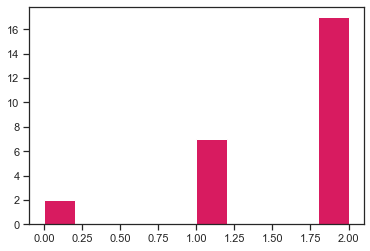

In [7]:
plt.hist(ham_dist_gc)

### GRL variants

In [8]:
grl_resistant = grl_variant[(grl_variant['hit']==True)&\
           (grl_variant['standardize_gal']<grl_variant['standardize_grl'])]

In [9]:
ham_dist_grl = []
for ind, row in grl_resistant.iterrows():
    res, aa = row['residue'], row['middle']
    wt_coding = DNA[res*3:(res+1)*3]
    ham_dist_list = []
    for coding in DNA_dict[aa]:
        ham_dist = hamming(wt_coding,coding)
        ham_dist_list.append(ham_dist)
    ham_dist_grl.append(min(ham_dist_list))

(array([ 2.,  0.,  0., 29.,  0.,  0., 42.,  0.,  0.,  4.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

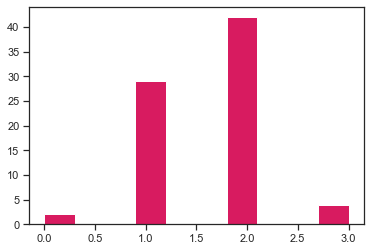

In [10]:
plt.hist(ham_dist_grl)

In [11]:
print(Counter(ham_dist_grl), Counter(ham_dist_gc))

Counter({2: 42, 1: 29, 3: 4, 0: 2}) Counter({2: 17, 1: 7, 0: 2})


### single mutation fitness

In [121]:
all_residues = matrix_transform.transform_matrix(
    'new_glu_gal', 'gal_glu.csv', samples, sets, res_redo, all_sets, set21)

In [157]:
bases = ['a', 'c', 't', 'g']
def activity(mut_from, mut_to):
    activity = []
    for res in range(1, 307):
        codon = DNA[3*res: 3*(res+1)]
        c_occur = [i for i, letter in enumerate(codon) if letter == mut_from]
        codon_list = list(codon)
        if len(c_occur)==1:
            t_sub = codon_list[:c_occur[0]]+[mut_to]+codon_list[c_occur[0]+1:]
            t_sub = "".join(t_sub)
            t_seq = str(Seq(t_sub).translate())
            activity_val = all_residues['Res '+ str(res)].loc[t_seq]
            activity.append(activity_val)
        elif len(c_occur) > 1:
            for sub in c_occur:
                t_sub = codon_list[:sub]+[mut_to]+codon_list[sub+1:]
                t_sub = "".join(t_sub)
                t_seq = str(Seq(t_sub).translate())
                activity_val = all_residues['Res '+ str(res)].loc[t_seq]
                activity.append(activity_val)
    return(activity)

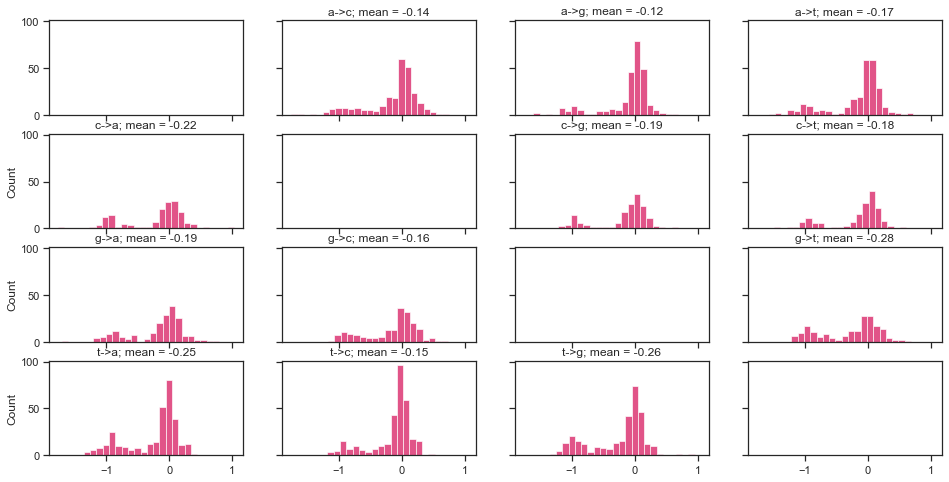

In [182]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True,figsize=(16,8))

for ind, a in enumerate(['a', 'c', 'g', 't']):
    for ind2, b in enumerate(['a', 'c', 'g', 't']):
        if a != b:
            act = activity(a, b)
            sns.histplot(act, ax=axes[ind, ind2], 
                         binwidth = 0.1).set_title(str(a)+'->'+str(b)+\
                        '; mean = ' +"{:0.2f}".format(np.mean(act)))
            
fig.savefig("Figures/FigS2_nucleotide_transition.png", dpi=400)